In [2]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
from notebook.services.config import ConfigManager
cm = ConfigManager().update('notebook', {'limit_output': 20})
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

In [4]:
Nor_path = "./Dataset/Normal_mixed.csv"
col_names = ["duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes",
                "land", "wrong_fragment", "urgent", "count", "srv_count", "serror_rate",
                "srv_serror_rate", "rerror_rate", "srv_rerror_rate", "same_srv_rate",
                "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
                "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
                "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate",
                "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"]
Nor_df = pd.read_csv(Nor_path, header=None,names= col_names, nrows= 100000)

In [5]:
Abnor_path = "./Dataset/Abnormal.csv"
Abnor_df = pd.read_csv(Abnor_path, header=None,names= col_names, nrows= 100000)

In [6]:
Train = pd.concat([Nor_df.iloc[:8000], Abnor_df.iloc[:8000]], ignore_index=True)
Train_nor = Nor_df.iloc[:8000]
Train_abnor = Abnor_df.iloc[:8000]

Test = pd.concat([Nor_df.iloc[-2000:], Abnor_df.iloc[-2000:]], ignore_index=True)
Test_nor = Nor_df.iloc[-2000:]
Test_abnor = Abnor_df.iloc[-2000:]

In [9]:
#Test Ver 1
Abnor_df_v1 = Abnor_df[Abnor_df['label'].isin(['FoT', 'DoS', 'DoS_Gas'])]
Test_v1 = pd.concat([Nor_df.iloc[-2000:], Abnor_df_v1[-2000:]],ignore_index=True)
Test_v1

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,count,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,other,OTH,66,0,0,0,0,79,...,28,0.19,0.81,0.00,0.64,0.0,0.0,0.0,0.0,Normal
1,0,tcp,other,OTH,66,0,0,0,0,178,...,54,0.60,0.40,0.00,0.41,0.0,0.0,0.0,0.0,Normal
2,0,tcp,other,OTH,66,0,0,0,0,9,...,11,0.44,0.56,0.17,0.64,0.0,0.0,0.0,0.0,Normal
3,0,tcp,http,OTH,290,0,0,0,0,107,...,43,1.00,0.00,0.36,0.70,0.0,0.0,0.0,0.0,Normal
4,0,tcp,other,OTH,66,0,0,0,0,2,...,9,1.00,0.00,0.00,0.78,0.0,0.0,0.0,0.0,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,0,tcp,http,OTH,54,0,0,0,0,9,...,43,1.00,0.00,0.41,0.79,0.0,0.0,0.0,0.0,DoS_Gas
3996,0,udp,other,SF,60,0,0,0,0,5452,...,100,1.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,DoS
3997,0,tcp,http,OTH,276,0,0,0,0,13,...,33,1.00,0.00,0.38,0.61,0.0,0.0,0.0,0.0,FoT
3998,0,tcp,http,OTH,60,0,0,0,0,18593,...,98,0.98,0.02,0.00,0.00,0.0,0.0,0.0,0.0,DoS


In [10]:
encoder = OneHotEncoder(handle_unknown='ignore')
scaler = MinMaxScaler()

In [11]:
def preprocess(df, is_fit=True):
    # chuyển normal thành 1 và các lớp khác thành 0
    label = df['label'].map(lambda x: 'Abnormal' if x != 'Normal' else x)

    # loại bỏ cột dữ liệu không cần thiết
    df.drop(["land", "wrong_fragment",  "urgent", "rerror_rate",  "srv_rerror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"], axis=1)

    # chia dữ liệu ra số, chữ để tiện xử lý
    numerical_data = df.select_dtypes(exclude='object').values
    categorical_data = df.select_dtypes(include='object').values

    # chỉ fit với dữ liệu train
    if is_fit:
        encoder.fit(categorical_data)

    # chuyển từ dữ liệu chữ sang onehot
    categorical_data = encoder.transform(categorical_data).toarray()

    # nối dữ liệu số và onehot lại
    data = np.concatenate([numerical_data, categorical_data], axis=1)

    # chỉ fit với dữ liệu train
    if is_fit:
        scaler.fit(data)

    # dữ liệu chuẩn hóa về dạng [0, 1]
    data = scaler.transform(data)

    return dict(data=data, label=label)

In [14]:
# xử lý dữ liệu
train = preprocess(Train, True)
test = preprocess(Test, False)
test_v1 = preprocess(Test_v1, False)

In [15]:
train['data'].shape, test['data'].shape, test_v1['data'].shape

((16000, 51), (4000, 51), (4000, 51))

In [16]:
# chia dữ liệu
Train_nor = train['data'][train['label'] == 'Normal']
Train_abnor = train['data'][train['label'] == 'Abnormal']

Test_nor = test['data'][test['label'] == 'Normal']
Test_abnor = test['data'][test['label'] == 'Abnormal']

Test_v1_nor = test_v1['data'][test_v1['label'] == 'Normal']
Test_v1_abnor = test_v1['data'][test_v1['label'] == 'Abnormal']

In [17]:
class Autoencoder(keras.Model):
  def __init__(self, input_dim):
    super(Autoencoder, self).__init__()
    self.encoder = keras.Sequential([
      # keras.layers.Dense(128, activation='tanh'),
      keras.layers.Dense(48, activation='tanh'),
      keras.layers.Dense(32, activation='tanh'),
      keras.layers.Dense(16, activation='tanh'),
      keras.layers.Dense(8, activation='tanh')
    ])
    self.decoder = keras.Sequential([
      keras.layers.Dense(16, activation='tanh'),
      keras.layers.Dense(32, activation='tanh'),
      keras.layers.Dense(48, activation='tanh'),
      # keras.layers.Dense(128, activation='tanh'),
      keras.layers.Dense(input_dim, activation='sigmoid'),
    ])

  def call(self, x):
    code = self.encoder(x)
    r = self.decoder(code)
    return r

  def get_reconstruction_error(self, x):
    r = self.predict(x)
    return keras.metrics.mean_squared_error(x, r)

  def predict_class(self, x, threshold):
    reconstruction_error = self.get_reconstruction_error(x)
    return np.where(reconstruction_error <= threshold, 'Normal', 'Abnormal')

In [18]:
model = Autoencoder(Train_nor.shape[1])
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
loss_fn = keras.losses.MeanSquaredError()
model.compile(optimizer, loss_fn)

In [19]:
model.fit(Train_nor, Train_nor, batch_size=64, epochs=500, shuffle=True)

Epoch 1/500
125/125 [==============================] - 2s 2ms/step - loss: 0.1979
Epoch 2/500
125/125 [==============================] - 0s 2ms/step - loss: 0.1256
Epoch 3/500
125/125 [==============================] - 0s 2ms/step - loss: 0.0796
Epoch 4/500
125/125 [==============================] - 0s 2ms/step - loss: 0.0625
Epoch 5/500
125/125 [==============================] - 0s 2ms/step - loss: 0.0554
Epoch 6/500
125/125 [==============================] - 0s 2ms/step - loss: 0.0505
Epoch 7/500
125/125 [==============================] - 0s 2ms/step - loss: 0.0465
Epoch 8/500
125/125 [==============================] - 0s 2ms/step - loss: 0.0432
Epoch 9/500
125/125 [==============================] - 0s 2ms/step - loss: 0.0407
Epoch 10/500
125/125 [==============================] - 0s 2ms/step - loss: 0.0386
Epoch 11/500
125/125 [==============================] - 0s 2ms/step - loss: 0.0369
Epoch 12/500
125/125 [==============================] - 0s 2ms/step - loss: 0.0354
Epoch 13/500


In [20]:
train_normal_re = model.get_reconstruction_error(Train_nor)
train_abnormal_re = model.get_reconstruction_error(Train_abnor)

test_normal_re = model.get_reconstruction_error(Test_nor)
test_abnormal_re = model.get_reconstruction_error(Test_abnor)

63/63 [==============================] - 0s 2ms/step


In [21]:
alpha = 0.5
threshold = np.concatenate([train_normal_re, train_abnormal_re]).mean() * alpha
print('Ngưỡng vừa tìm được từ tập train:', threshold)

Ngưỡng vừa tìm được từ tập train: 0.014820673502981663


63/63 [==============================] - 0s 2ms/step
Độ chính xác tập khi tái tạo normal tập huấn luyện: 0.996
500/500 [==============================] - 1s 1ms/step
Độ chính xác tập huấn luyện: 0.9990625
125/125 [==============================] - 0s 1ms/step
Độ chính xác tập test: 0.998
125/125 [==============================] - 0s 1ms/step
Độ chính xác tập test kịch bản 1: 0.998


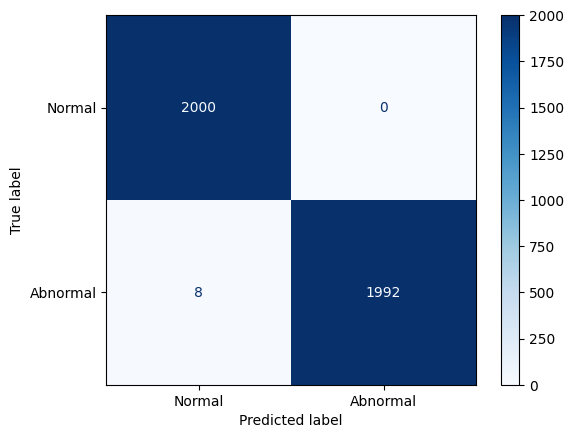

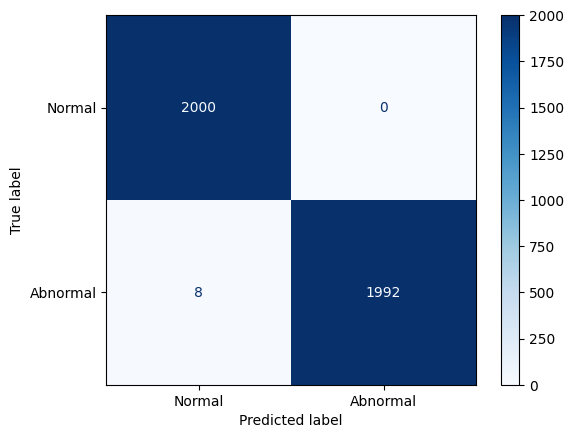

In [23]:
label_predict = model.predict_class(Test_nor, threshold)
print('Độ chính xác tập khi tái tạo normal tập huấn luyện', end=': ')
print(accuracy_score(np.full([2000], 'Normal'), label_predict))

label_predict = model.predict_class(train['data'], threshold)
print('Độ chính xác tập huấn luyện', end=': ')
print(accuracy_score(train['label'], label_predict))

label_predict = model.predict_class(test['data'], threshold)
print('Độ chính xác tập test', end=': ')
print(accuracy_score(test['label'], label_predict))

#Test ver 1
label_predict_v1 = model.predict_class(test_v1['data'], threshold)
print('Độ chính xác tập test kịch bản 1', end=': ')
print(accuracy_score(test_v1['label'], label_predict_v1))

labels = ['Normal', 'Abnormal']
matrix = confusion_matrix(test['label'], label_predict)
disp = ConfusionMatrixDisplay(
    confusion_matrix=matrix, display_labels=labels)

disp.plot(cmap=plt.cm.Blues)

matrix_v1 = confusion_matrix(test_v1['label'], label_predict_v1)
disp = ConfusionMatrixDisplay(
    confusion_matrix=matrix_v1, display_labels=labels)

disp.plot(cmap=plt.cm.Blues)

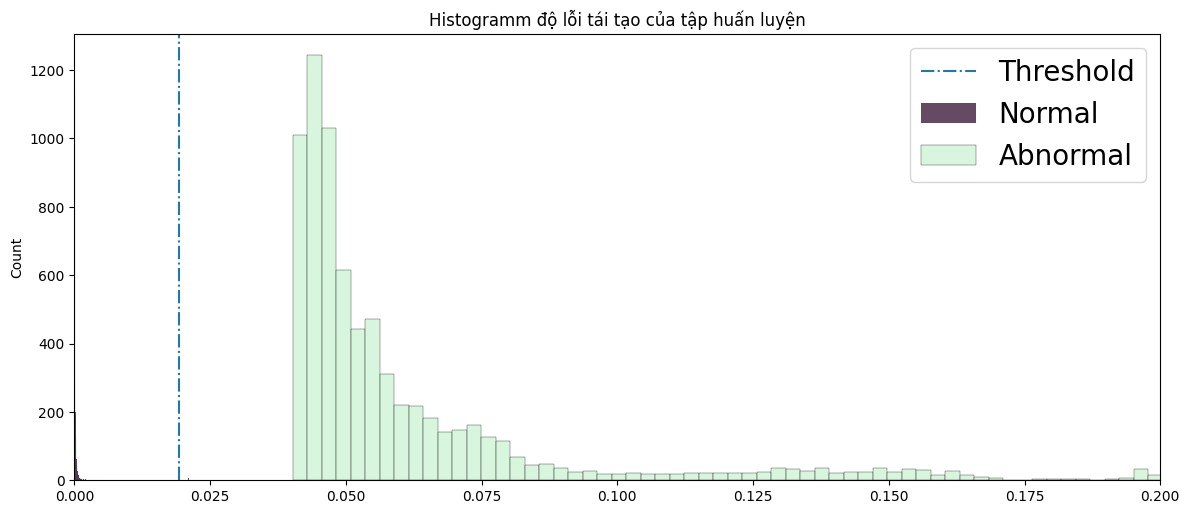

In [38]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(12, 5))
sns.histplot(data=train_normal_re, label='Normal', kde=False, ax=ax, color='#330C2F')
sns.histplot(data=train_abnormal_re, label='Abnormal', kde=False, ax=ax, color='#CBF3D2')
ax.axvline(threshold, ls='-.', label='Threshold')
ax.legend(loc='best', fontsize=20)
ax.set_xlim([0, 0.2])
fig.tight_layout()
plt.title('Histogramm độ lỗi tái tạo của tập huấn luyện')
plt.show()

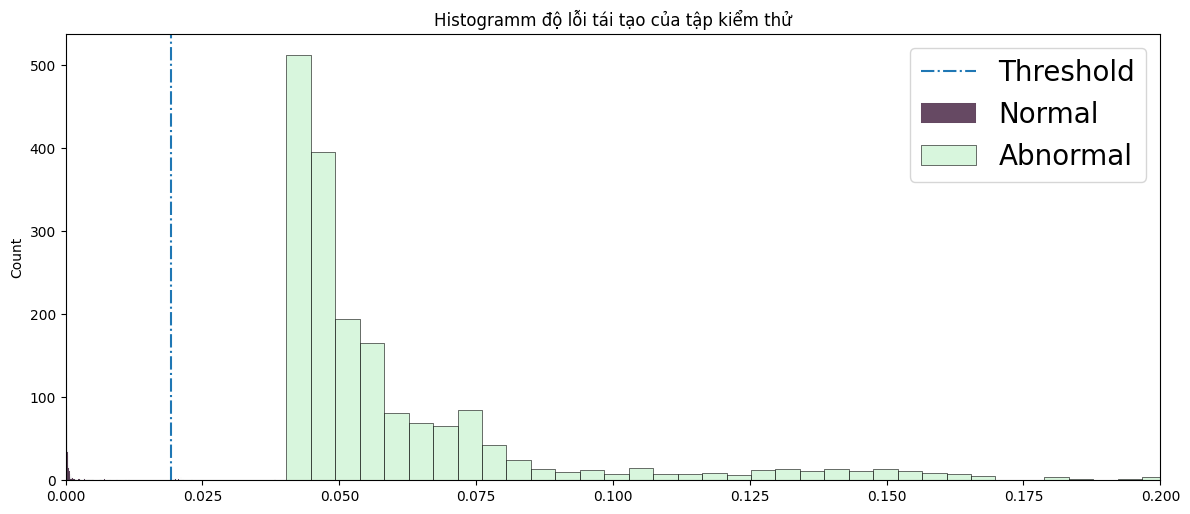

In [39]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.histplot(data=test_normal_re, label='Normal', kde=False, ax=ax, color='#330C2F')
sns.histplot(data=test_abnormal_re, label='Abnormal', kde=False, ax=ax, color='#CBF3D2')
ax.axvline(threshold, ls='-.', label='Threshold')
ax.legend(loc='best', fontsize=20)
ax.set_xlim([0, 0.2])
fig.tight_layout()
plt.title('Histogramm độ lỗi tái tạo của tập kiểm thử')
plt.show()